# MAS 651 Mid-term Project: Predicting HDL Cholesterol with Deep Learning

**GitHub Repository**: https://github.com/rvargasm7/hdl-prediction-project

**Team**: Rolando Vargas, Eleniz Espina, Bryce Leister

## Project Overview
This notebook predicts HDL cholesterol (LBDHDD_outcome) using demographic,
dietary, behavioral, and body-measure variables from the NHANES dataset.

**Target Variable:** LBDHDD_outcome (noise-perturbed Direct HDL-Cholesterol,
mg/dL)

**Data Access**: Preprocessed data available at https://github.com/rvargasm7/hdl-prediction-project/tree/main/data

### Structure:
1. Setup and Data Loading
2. Data Quality and Structure Visualization (Task A)
3. Relationships Visualization (Task B)
4. Predictive Analysis - Baselines + Deep Learning (Task C)
5. Model Comparison and Stacking Ensemble
6. Summary and Conclusions

## 1. Setup and Data Loading

In [47]:
"""Install required packages if needed."""
!pip install pyreadr pandas numpy matplotlib seaborn scikit-learn xgboost catboost tensorflow keras optuna -q

In [48]:
"""Import all required libraries for data analysis and modeling."""
import warnings
import tempfile
import requests
import pyreadr

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.ndimage import uniform_filter1d

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (
    LinearRegression,
    ElasticNet,
    ElasticNetCV,
    Ridge,
    RidgeCV,
    Lasso,
)
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
)
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Matplotlib settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.style.use('seaborn-v0_8-whitegrid')

# Target variable
TARGET_COL = 'LBDHDD_outcome'

print("All libraries imported successfully!")

All libraries imported successfully!


In [49]:
def read_rds_from_url(url):
    """Download and read RDS file from URL.

    Args:
        url: URL to the RDS file.

    Returns:
        pandas.DataFrame: The loaded data.
    """
    response = requests.get(url)
    response.raise_for_status()
    with tempfile.NamedTemporaryFile(suffix=".rds") as temp_file:
        temp_file.write(response.content)
        temp_file.flush()
        obj = pyreadr.read_r(temp_file.name)
    return list(obj.values())[0]


# Load training and test data
print("Loading data from ASASF...")
TRAIN_URL = "https://luminwin.github.io/ASASF/train.rds"
TEST_URL = "https://luminwin.github.io/ASASF/test.rds"

train_df = read_rds_from_url(TRAIN_URL)
test_df = read_rds_from_url(TEST_URL)

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

Loading data from ASASF...
Training data shape: (1000, 96)
Test data shape: (200, 95)


In [50]:
"""Save preprocessed data to CSV for reproducibility."""
import os

# Save to data/ directory
data_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), "data")
os.makedirs(data_dir, exist_ok=True)

train_csv_path = os.path.join(data_dir, "train_processed.csv")
test_csv_path = os.path.join(data_dir, "test_processed.csv")

train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print(f"Training data saved to {train_csv_path} ({train_df.shape})")
print(f"Test data saved to {test_csv_path} ({test_df.shape})")


Training data saved to /Users/rolandovargas/Documents/MastersUM/MAS635 - Machine Learning Methods AI/MidtermProject/data/train_processed.csv ((1000, 96))
Test data saved to /Users/rolandovargas/Documents/MastersUM/MAS635 - Machine Learning Methods AI/MidtermProject/data/test_processed.csv ((200, 95))


In [51]:
"""Initial data exploration."""
print("Training Data - First 5 rows:")
display(train_df.head())

Training Data - First 5 rows:


,LBDHDD_outcome,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,...,RIAGENDR,INDFMPIR,DMDMARTZ,RIDAGEYR,RIDRETH1,RIDRETH3,BMXBMI,BMXWAIST,ALQ111,ALQ121
0,51.169706,1459.0,39.95,152.46,50.34,13.6,78.41,18.062,29.440,24.306,...,2.0,2.17,1.0,72.0,5.0,7.0,34.3,115.1,1.0,10.0
1,64.129747,2116.0,82.54,213.12,75.49,12.7,103.08,48.495,23.529,17.248,...,2.0,1.03,1.0,61.0,2.0,2.0,22.6,77.3,1.0,7.0
2,43.333345,2417.0,61.59,242.22,69.35,14.7,104.62,30.182,31.087,33.534,...,1.0,3.31,1.0,40.0,3.0,3.0,27.9,106.5,1.0,3.0
3,58.853188,2018.0,39.99,206.45,50.56,17.2,42.75,12.418,13.011,12.525,...,2.0,3.82,1.0,74.0,3.0,3.0,36.5,112.2,1.0,1.0
4,40.239688,2331.0,89.59,307.36,161.17,20.1,85.28,22.278,30.190,25.063,...,1.0,2.58,2.0,80.0,3.0,3.0,24.9,102.6,1.0,8.0


In [52]:
"""Check data types and info."""
print("\nTraining Data Info:")
train_df.info()


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 96 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   LBDHDD_outcome  1000 non-null   float64
 1   DR1TKCAL        1000 non-null   float64
 2   DR1TPROT        1000 non-null   float64
 3   DR1TCARB        1000 non-null   float64
 4   DR1TSUGR        1000 non-null   float64
 5   DR1TFIBE        1000 non-null   float64
 6   DR1TTFAT        1000 non-null   float64
 7   DR1TSFAT        1000 non-null   float64
 8   DR1TMFAT        1000 non-null   float64
 9   DR1TPFAT        1000 non-null   float64
 10  DR1TCHOL        1000 non-null   float64
 11  DR1TATOC        1000 non-null   float64
 12  DR1TATOA        1000 non-null   float64
 13  DR1TRET         1000 non-null   float64
 14  DR1TVARA        1000 non-null   float64
 15  DR1TACAR        1000 non-null   float64
 16  DR1TBCAR        1000 non-null   float64
 17  DR1TCRYP     

In [53]:
"""Display basic statistics."""
print("\nTraining Data Statistics:")
display(train_df.describe())


Training Data Statistics:


,LBDHDD_outcome,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,...,RIAGENDR,INDFMPIR,DMDMARTZ,RIDAGEYR,RIDRETH1,RIDRETH3,BMXBMI,BMXWAIST,ALQ111,ALQ121
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000
mean,54.733860,2020.360000,75.083040,226.424160,96.492660,16.858100,85.609300,27.762500,28.814114,19.787024,...,1.522000,3.315000,1.670000,54.474000,3.092000,3.233000,30.047200,102.436800,1.0,5.008000
std,9.010594,878.567665,35.072536,108.422154,66.904216,9.623927,44.880046,16.849451,15.863507,12.800487,...,0.499766,1.596234,3.175403,16.255201,0.866191,1.228096,6.741877,16.692296,0.0,4.594676
min,30.034304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,20.000000,1.000000,1.000000,16.900000,64.400000,1.0,0.000000
25%,47.994034,1440.000000,50.315000,151.147500,51.375000,10.300000,54.540000,15.977000,17.953750,11.155000,...,1.000000,1.920000,1.000000,40.000000,3.000000,3.000000,25.200000,90.275000,1.0,2.000000
50%,54.159576,1882.500000,68.395000,213.020000,82.315000,15.200000,78.365000,24.873500,26.094000,17.180500,...,2.000000,3.470000,1.000000,59.000000,3.000000,3.000000,29.050000,101.400000,1.0,5.000000
75%,60.879150,2491.000000,95.245000,280.710000,124.477500,22.000000,107.657500,35.119000,36.730250,24.944750,...,2.000000,5.000000,2.000000,67.000000,3.000000,3.000000,33.700000,112.325000,1.0,8.000000
max,86.705504,7090.000000,238.690000,891.920000,775.200000,68.800000,447.630000,153.511000,124.704000,130.272000,...,2.000000,5.000000,99.000000,80.000000,5.000000,7.000000,63.400000,163.200000,1.0,77.000000


In [54]:
"""Check target variable statistics."""
TARGET_COL = 'LBDHDD_outcome'

print(f"\nTarget Variable ({TARGET_COL}):")
print(f"Mean: {train_df[TARGET_COL].mean():.2f}")
print(f"Std: {train_df[TARGET_COL].std():.2f}")
print(f"Min: {train_df[TARGET_COL].min():.2f}")
print(f"Max: {train_df[TARGET_COL].max():.2f}")
print(f"Missing: {train_df[TARGET_COL].isna().sum()}")


Target Variable (LBDHDD_outcome):
Mean: 54.73
Std: 9.01
Min: 30.03
Max: 86.71
Missing: 0


## 2. Data Quality and Structure Visualization (Task A)

### 2.1 Missingness by Feature

In [55]:
"""Calculate missing values percentage."""
missing_pct = (
    train_df.isnull().sum() / len(train_df) * 100
).sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]

print(f"Total features with missing values: {len(missing_pct)}")
print(f"\nTop 20 features with highest missingness:")
print(missing_pct.head(20))

Total features with missing values: 0

Top 20 features with highest missingness:
Series([], dtype: float64)


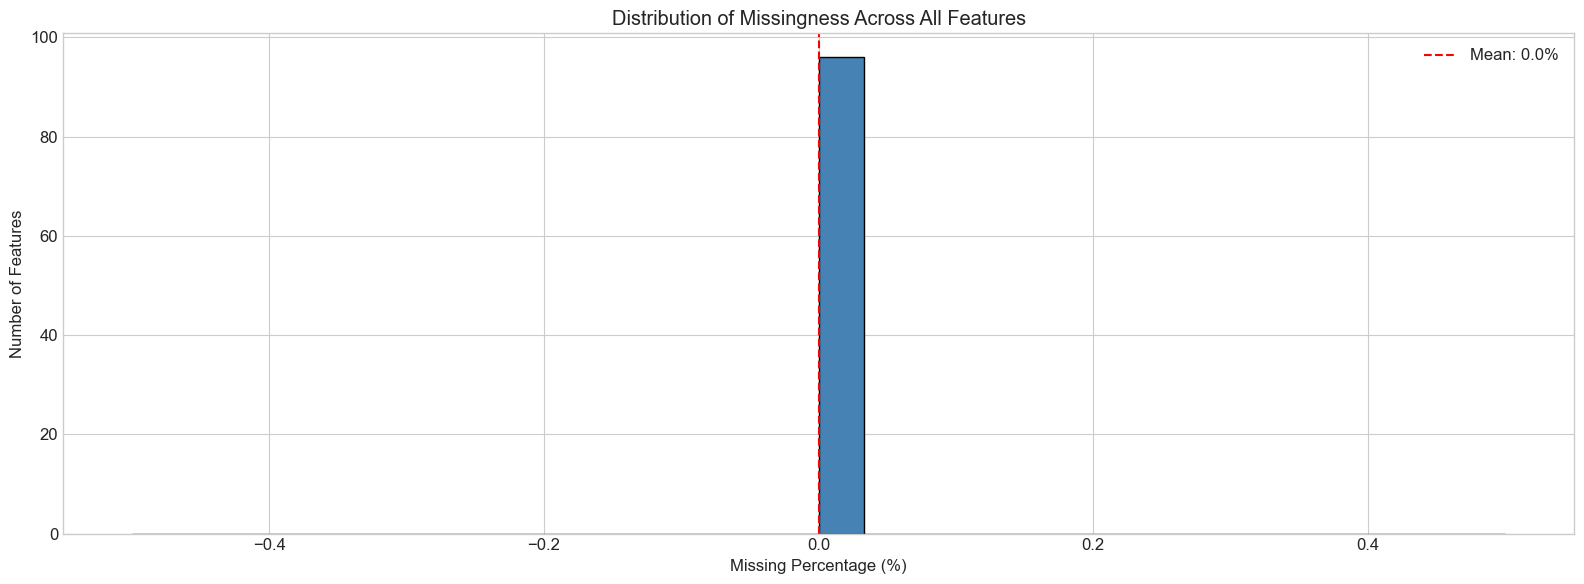

In [56]:
"""Visualize missingness patterns."""
fig, ax = plt.subplots(figsize=(16, 6))

# Distribution of missingness across all features
all_missing = train_df.isnull().sum() / len(train_df) * 100
ax.hist(all_missing, bins=30, color='steelblue', edgecolor='black')
ax.set_xlabel('Missing Percentage (%)')
ax.set_ylabel('Number of Features')
ax.set_title('Distribution of Missingness Across All Features')
ax.axvline(
    x=all_missing.mean(),
    color='red',
    linestyle='--',
    label=f'Mean: {all_missing.mean():.1f}%',
)
ax.legend()

plt.tight_layout()
plt.savefig('outputs/figures/missingness_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

### 2.2 Target Distribution (Histogram + Density)

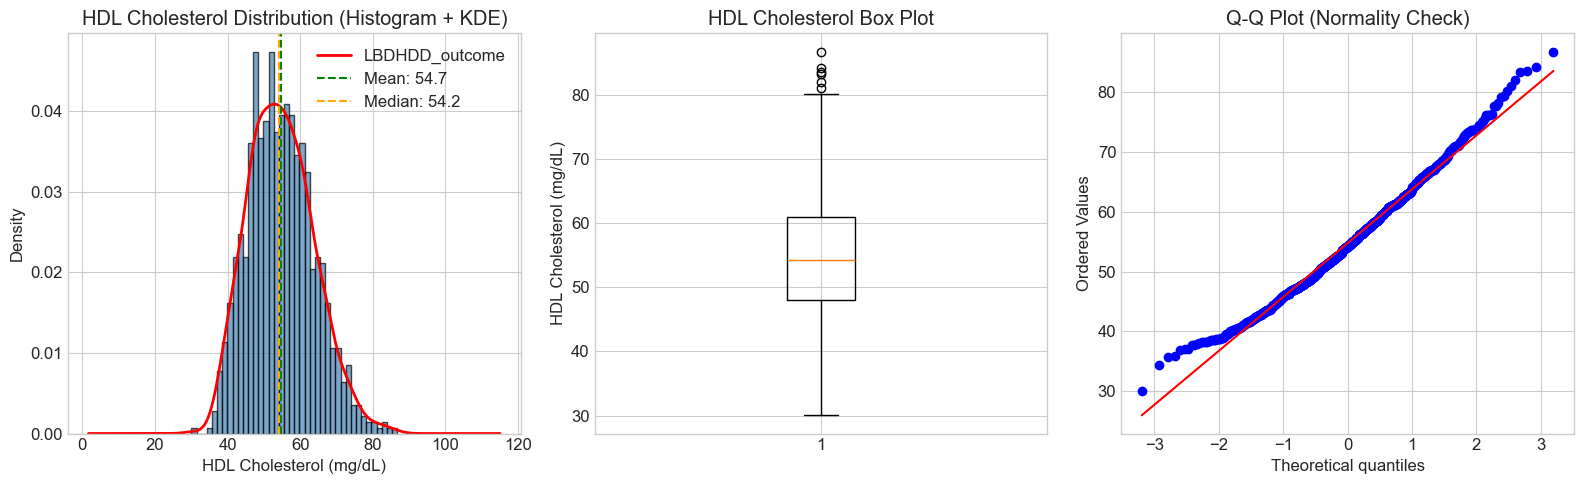


Target Distribution Statistics:
Skewness: 0.376
Kurtosis: -0.040


In [57]:
"""Visualize target variable distribution."""
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

target_data = train_df[TARGET_COL].dropna()

# Histogram with KDE
axes[0].hist(
    target_data,
    bins=40,
    density=True,
    alpha=0.7,
    color='steelblue',
    edgecolor='black',
)
target_data.plot.kde(ax=axes[0], color='red', linewidth=2)
axes[0].set_xlabel('HDL Cholesterol (mg/dL)')
axes[0].set_ylabel('Density')
axes[0].set_title('HDL Cholesterol Distribution (Histogram + KDE)')
axes[0].axvline(
    target_data.mean(),
    color='green',
    linestyle='--',
    label=f'Mean: {target_data.mean():.1f}',
)
axes[0].axvline(
    target_data.median(),
    color='orange',
    linestyle='--',
    label=f'Median: {target_data.median():.1f}',
)
axes[0].legend()

# Box plot
axes[1].boxplot(target_data, vert=True)
axes[1].set_ylabel('HDL Cholesterol (mg/dL)')
axes[1].set_title('HDL Cholesterol Box Plot')

# Q-Q plot
stats.probplot(target_data, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Normality Check)')

plt.tight_layout()
plt.savefig('outputs/figures/target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Skewness and Kurtosis
print(f"\nTarget Distribution Statistics:")
print(f"Skewness: {target_data.skew():.3f}")
print(f"Kurtosis: {target_data.kurtosis():.3f}")

### 2.3 Correlation Heatmap for Top Correlated Numeric Features

In [58]:
"""Calculate correlations with target variable."""
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Number of numeric features: {len(numeric_cols)}")

# Calculate correlations with target
correlations = (
    train_df[numeric_cols]
    .corr()[TARGET_COL]
    .drop(TARGET_COL)
    .abs()
    .sort_values(ascending=False)
)
print(f"\nTop 20 features correlated with HDL:")
print(correlations.head(20))

Number of numeric features: 96

Top 20 features correlated with HDL:
BMXWAIST    0.595812
RIAGENDR    0.522740
BMXBMI      0.483975
DR1TNUMF    0.188157
DR1TALCO    0.170589
INDFMPIR    0.169201
DR1BWATZ    0.164396
DR1TVK      0.156818
DR1TVC      0.156080
DR1TLZ      0.141205
DR1TP204    0.135297
DR1TBCAR    0.133542
DR1TSUGR    0.133169
DR1TCARB    0.129983
DRQSPREP    0.117522
DR1TFF      0.116210
DR1TS180    0.107544
DR1TM161    0.097463
DR1TPROT    0.096097
DR1TCRYP    0.095674
Name: LBDHDD_outcome, dtype: float64


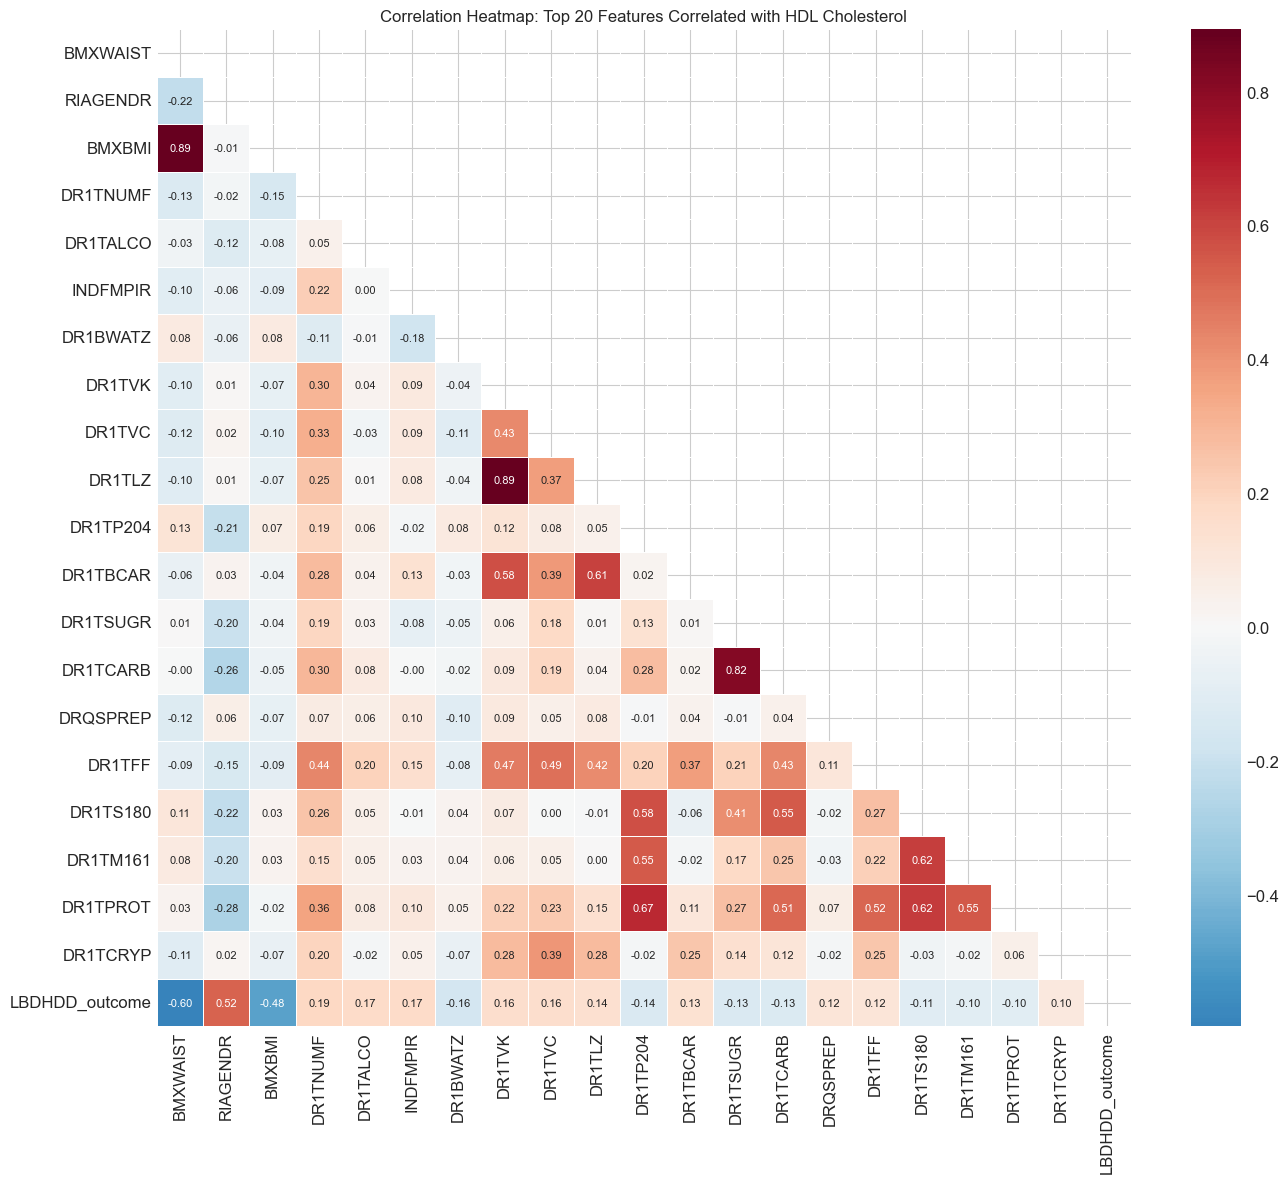

In [59]:
"""Create correlation heatmap for top correlated features."""
top_features = correlations.head(20).index.tolist()
top_features.append(TARGET_COL)

corr_matrix = train_df[top_features].corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    linewidths=0.5,
    annot_kws={'size': 8},
)
plt.title(
    'Correlation Heatmap: Top 20 Features Correlated with HDL Cholesterol',
    fontsize=12,
)
plt.tight_layout()
plt.savefig('outputs/figures/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Relationships Visualization (Task B)

### 3.1 HDL vs BMI (Scatter + Trend Line)

In [60]:
"""Find BMI and body measurement columns."""
bmi_cols = [
    col for col in train_df.columns
    if 'BMI' in col.upper() or 'bmi' in col.lower()
]
print(f"BMI-related columns found: {bmi_cols}")

body_cols = [
    col for col in train_df.columns
    if 'BMX' in col or 'body' in col.lower()
]
print(f"Body measurement columns: {body_cols[:20]}")

BMI-related columns found: ['BMXBMI']
Body measurement columns: ['BMXBMI', 'BMXWAIST']


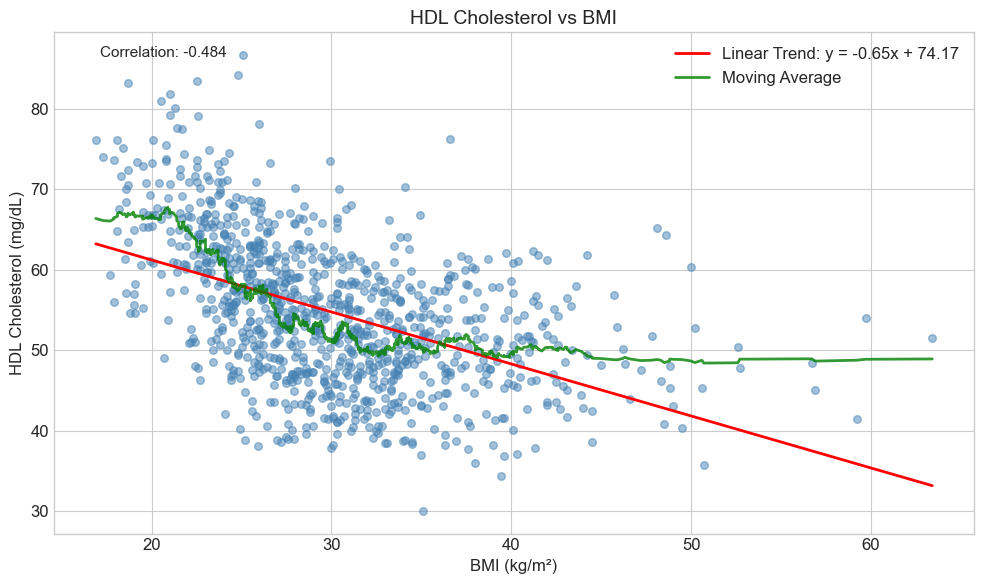

In [61]:
def find_column_by_patterns(df, patterns):
    """Find a column matching any of the given patterns.

    Args:
        df: DataFrame to search.
        patterns: List of patterns to match.

    Returns:
        str or None: Matching column name or None.
    """
    for col in df.columns:
        for pattern in patterns:
            if pattern in col.upper():
                return col
    return None


# Find BMI column
bmi_col = find_column_by_patterns(train_df, ['BMXBMI', 'BMI'])

if bmi_col:
    fig, ax = plt.subplots(figsize=(10, 6))

    valid_data = train_df[[bmi_col, TARGET_COL]].dropna()

    # Scatter plot
    ax.scatter(
        valid_data[bmi_col],
        valid_data[TARGET_COL],
        alpha=0.5,
        c='steelblue',
        s=30,
    )

    # Trend line (linear regression)
    coefficients = np.polyfit(
        valid_data[bmi_col],
        valid_data[TARGET_COL],
        1,
    )
    poly = np.poly1d(coefficients)
    x_line = np.linspace(
        valid_data[bmi_col].min(),
        valid_data[bmi_col].max(),
        100,
    )
    ax.plot(
        x_line,
        poly(x_line),
        'r-',
        linewidth=2,
        label=f'Linear Trend: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}',
    )

    # Add moving average smoothing
    sorted_idx = valid_data[bmi_col].argsort()
    x_sorted = valid_data[bmi_col].iloc[sorted_idx]
    y_sorted = valid_data[TARGET_COL].iloc[sorted_idx]
    y_smooth = uniform_filter1d(y_sorted, size=50)
    ax.plot(
        x_sorted,
        y_smooth,
        'g-',
        linewidth=2,
        alpha=0.8,
        label='Moving Average',
    )

    ax.set_xlabel('BMI (kg/m²)', fontsize=12)
    ax.set_ylabel('HDL Cholesterol (mg/dL)', fontsize=12)
    ax.set_title('HDL Cholesterol vs BMI', fontsize=14)
    ax.legend()

    # Add correlation annotation
    corr = valid_data[bmi_col].corr(valid_data[TARGET_COL])
    ax.annotate(
        f'Correlation: {corr:.3f}',
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=11,
    )

    plt.tight_layout()
    plt.savefig('outputs/figures/hdl_vs_bmi.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("BMI column not found in the dataset")

### 3.2 HDL by Subgroups (Box/Violin Plots)

In [62]:
"""Find categorical columns for subgroup analysis."""
cat_cols = train_df.select_dtypes(
    include=['object', 'category']
).columns.tolist()
print(f"Categorical columns: {cat_cols}")

# Check for potential demographic columns
demo_keywords = [
    'SEX', 'GENDER', 'RACE', 'ETHNIC', 'SMOKE', 'AGE', 'RIDRETH', 'SMQ',
]
potential_demo = [
    col for col in train_df.columns
    if any(kw in col.upper() for kw in demo_keywords)
]
print(f"\nPotential demographic columns: {potential_demo}")

Categorical columns: []

Potential demographic columns: ['RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'RIDRETH3']


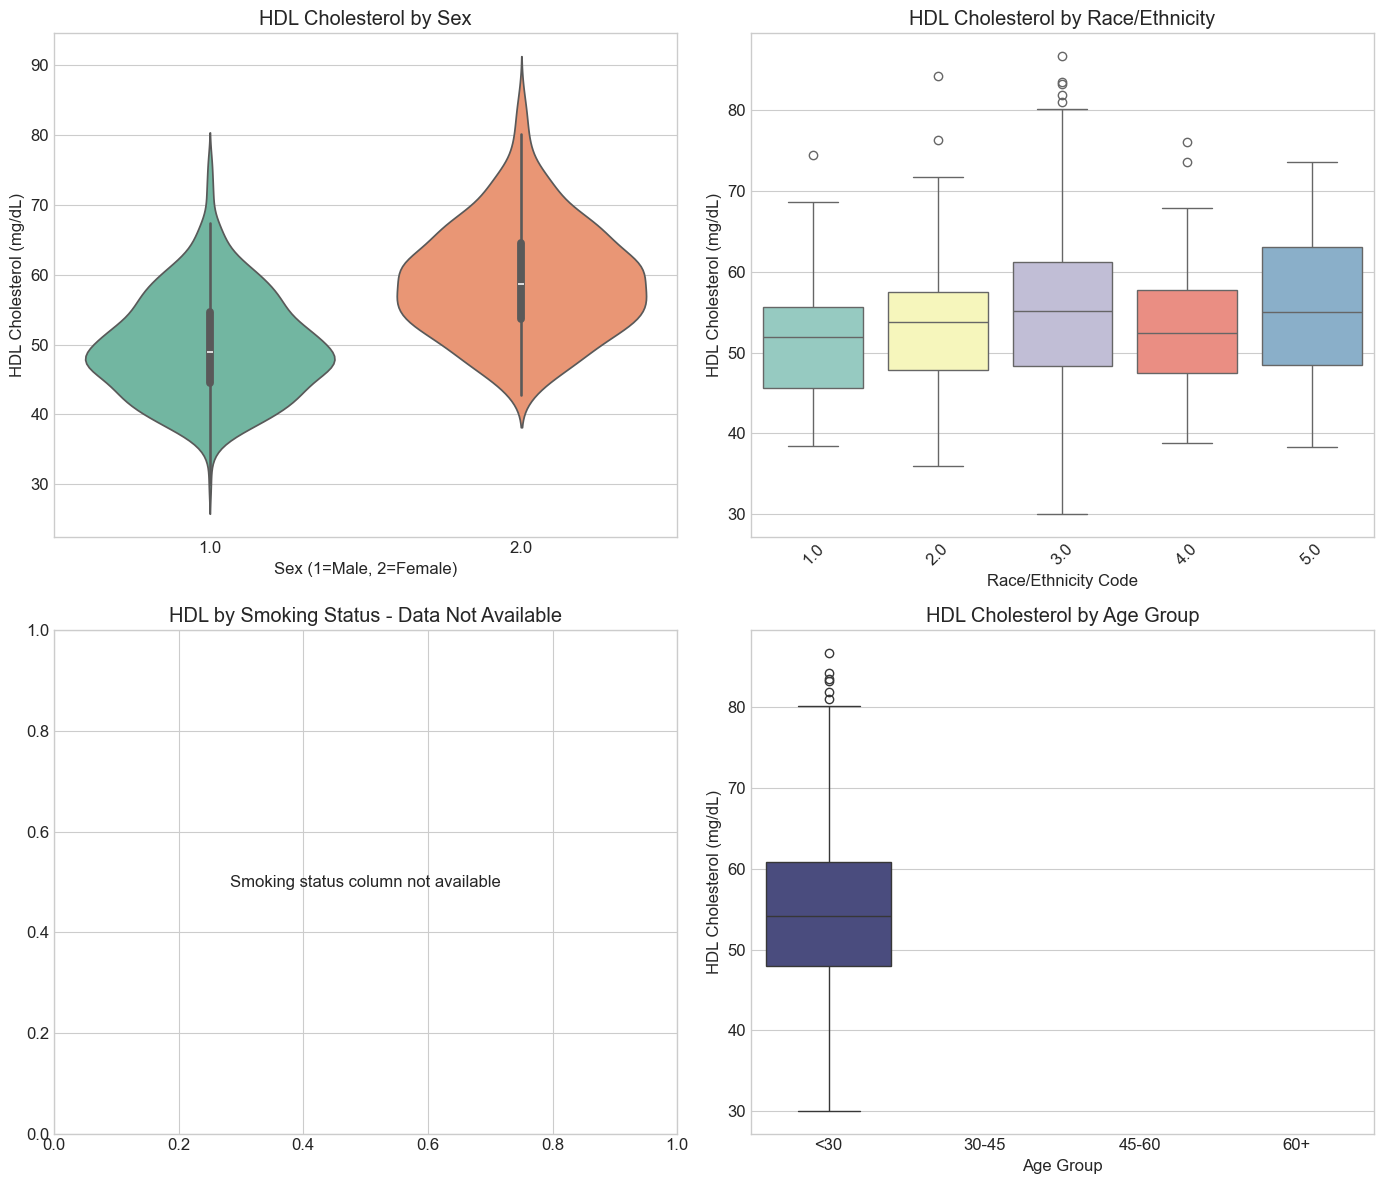

In [63]:
"""Create subgroup visualizations."""
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Find relevant demographic columns
sex_col = find_column_by_patterns(train_df, ['RIAGENDR', 'SEX'])
race_col = find_column_by_patterns(train_df, ['RIDRETH'])
smoke_col = find_column_by_patterns(train_df, ['SMQ020', 'SMOKE'])
age_col = find_column_by_patterns(train_df, ['RIDAGEYR', 'AGE'])

# Plot 1: HDL by Sex
if sex_col and sex_col in train_df.columns:
    data = train_df[[sex_col, TARGET_COL]].dropna()
    if len(data) > 0:
        sns.violinplot(
            data=data,
            x=sex_col,
            y=TARGET_COL,
            ax=axes[0, 0],
            palette='Set2',
        )
        axes[0, 0].set_title('HDL Cholesterol by Sex')
        axes[0, 0].set_xlabel('Sex (1=Male, 2=Female)')
        axes[0, 0].set_ylabel('HDL Cholesterol (mg/dL)')
else:
    axes[0, 0].text(
        0.5, 0.5,
        'Sex column not available',
        ha='center',
        va='center',
    )
    axes[0, 0].set_title('HDL by Sex - Data Not Available')

# Plot 2: HDL by Race/Ethnicity
if race_col and race_col in train_df.columns:
    data = train_df[[race_col, TARGET_COL]].dropna()
    if len(data) > 0:
        sns.boxplot(
            data=data,
            x=race_col,
            y=TARGET_COL,
            ax=axes[0, 1],
            palette='Set3',
        )
        axes[0, 1].set_title('HDL Cholesterol by Race/Ethnicity')
        axes[0, 1].set_xlabel('Race/Ethnicity Code')
        axes[0, 1].set_ylabel('HDL Cholesterol (mg/dL)')
        axes[0, 1].tick_params(axis='x', rotation=45)
else:
    axes[0, 1].text(
        0.5, 0.5,
        'Race/Ethnicity column not available',
        ha='center',
        va='center',
    )
    axes[0, 1].set_title('HDL by Race/Ethnicity - Data Not Available')

# Plot 3: HDL by Smoking Status
if smoke_col and smoke_col in train_df.columns:
    data = train_df[[smoke_col, TARGET_COL]].dropna()
    if len(data) > 0:
        sns.violinplot(
            data=data,
            x=smoke_col,
            y=TARGET_COL,
            ax=axes[1, 0],
            palette='coolwarm',
        )
        axes[1, 0].set_title('HDL Cholesterol by Smoking Status')
        axes[1, 0].set_xlabel('Smoking Status')
        axes[1, 0].set_ylabel('HDL Cholesterol (mg/dL)')
else:
    axes[1, 0].text(
        0.5, 0.5,
        'Smoking status column not available',
        ha='center',
        va='center',
    )
    axes[1, 0].set_title('HDL by Smoking Status - Data Not Available')

# Plot 4: HDL by Age Groups
if age_col and age_col in train_df.columns:
    data = train_df[[age_col, TARGET_COL]].dropna().copy()
    if len(data) > 0:
        data['Age_Group'] = pd.cut(
            data[age_col],
            bins=[0, 30, 45, 60, 100],
            labels=['<30', '30-45', '45-60', '60+'],
        )
        sns.boxplot(
            data=data,
            x='Age_Group',
            y=TARGET_COL,
            ax=axes[1, 1],
            palette='viridis',
        )
        axes[1, 1].set_title('HDL Cholesterol by Age Group')
        axes[1, 1].set_xlabel('Age Group')
        axes[1, 1].set_ylabel('HDL Cholesterol (mg/dL)')
else:
    axes[1, 1].text(
        0.5, 0.5,
        'Age column not available',
        ha='center',
        va='center',
    )
    axes[1, 1].set_title('HDL by Age Group - Data Not Available')

plt.tight_layout()
plt.savefig('outputs/figures/hdl_by_subgroups.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.3 Diet/Nutrient Intake vs HDL

In [64]:
"""Find dietary/nutrient columns."""
nutrient_keywords = [
    'DR', 'DIET', 'CALOR', 'FAT', 'PROTEIN',
    'CARB', 'FIBER', 'SUGAR', 'SODIUM', 'CHOL',
]
nutrient_cols = [
    col for col in train_df.columns
    if any(kw in col.upper() for kw in nutrient_keywords)
    and col != TARGET_COL
]
print(f"Nutrient-related columns found: {len(nutrient_cols)}")
print(nutrient_cols[:20])

Nutrient-related columns found: 87
['DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR', 'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL', 'DR1TATOC', 'DR1TATOA', 'DR1TRET', 'DR1TVARA', 'DR1TACAR', 'DR1TBCAR', 'DR1TCRYP', 'DR1TLYCO', 'DR1TLZ', 'DR1TVB1']


Top 4 correlated nutrient variables: ['RIAGENDR', 'DR1TNUMF', 'DR1TALCO', 'DR1BWATZ']


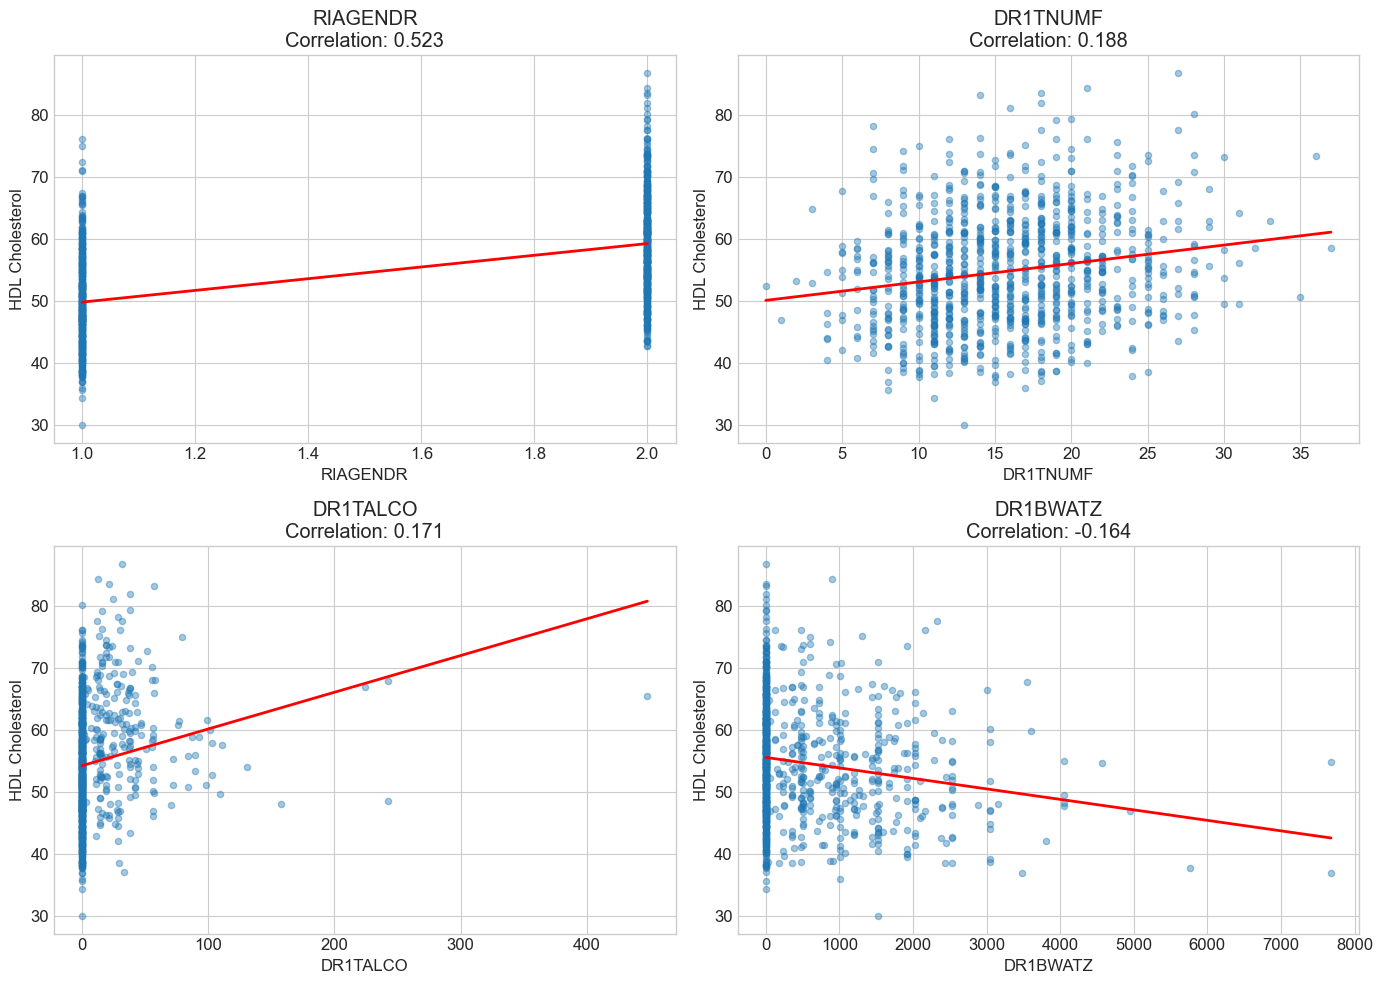

In [65]:
"""Visualize relationships between nutrients and HDL."""
if nutrient_cols:
    # Calculate correlations with target
    nutrient_corrs = (
        train_df[nutrient_cols + [TARGET_COL]]
        .corr()[TARGET_COL]
        .drop(TARGET_COL)
        .abs()
        .sort_values(ascending=False)
    )
    top_nutrients = nutrient_corrs.head(4).index.tolist()
    print(f"Top 4 correlated nutrient variables: {top_nutrients}")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for i, col in enumerate(top_nutrients):
        if i < 4:
            valid_data = train_df[[col, TARGET_COL]].dropna()
            if len(valid_data) > 10:
                # Scatter plot
                axes[i].scatter(
                    valid_data[col],
                    valid_data[TARGET_COL],
                    alpha=0.4,
                    s=20,
                )

                # Trend line
                coeffs = np.polyfit(
                    valid_data[col],
                    valid_data[TARGET_COL],
                    1,
                )
                poly = np.poly1d(coeffs)
                x_line = np.linspace(
                    valid_data[col].min(),
                    valid_data[col].max(),
                    100,
                )
                axes[i].plot(x_line, poly(x_line), 'r-', linewidth=2)

                corr = valid_data[col].corr(valid_data[TARGET_COL])
                axes[i].set_title(f'{col}\nCorrelation: {corr:.3f}')
                axes[i].set_xlabel(col)
                axes[i].set_ylabel('HDL Cholesterol')

    plt.tight_layout()
    plt.savefig('outputs/figures/hdl_vs_nutrients.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No nutrient columns found")

### 3.4 Waist Circumference vs HDL

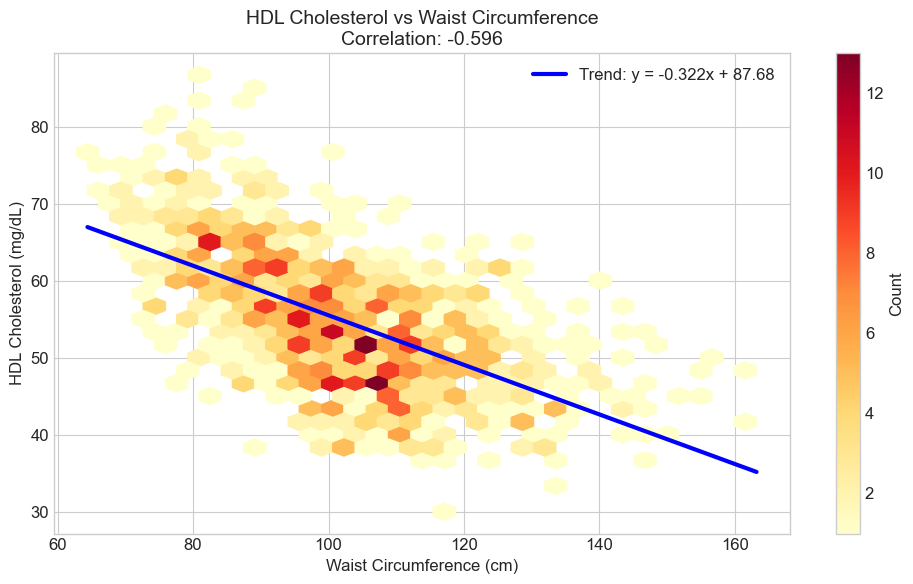

In [66]:
"""Visualize waist circumference vs HDL relationship."""
waist_col = find_column_by_patterns(train_df, ['BMXWAIST', 'WAIST'])

if waist_col:
    fig, ax = plt.subplots(figsize=(10, 6))

    valid_data = train_df[[waist_col, TARGET_COL]].dropna()

    # Hexbin plot for density visualization
    hb = ax.hexbin(
        valid_data[waist_col],
        valid_data[TARGET_COL],
        gridsize=30,
        cmap='YlOrRd',
        mincnt=1,
    )
    plt.colorbar(hb, ax=ax, label='Count')

    # Trend line
    coeffs = np.polyfit(
        valid_data[waist_col],
        valid_data[TARGET_COL],
        1,
    )
    poly = np.poly1d(coeffs)
    x_line = np.linspace(
        valid_data[waist_col].min(),
        valid_data[waist_col].max(),
        100,
    )
    ax.plot(
        x_line,
        poly(x_line),
        'b-',
        linewidth=3,
        label=f'Trend: y = {coeffs[0]:.3f}x + {coeffs[1]:.2f}',
    )

    corr = valid_data[waist_col].corr(valid_data[TARGET_COL])
    ax.set_xlabel('Waist Circumference (cm)', fontsize=12)
    ax.set_ylabel('HDL Cholesterol (mg/dL)', fontsize=12)
    ax.set_title(
        f'HDL Cholesterol vs Waist Circumference\nCorrelation: {corr:.3f}',
        fontsize=14,
    )
    ax.legend()

    plt.tight_layout()
    plt.savefig('outputs/figures/hdl_vs_waist.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Waist circumference column not found")
    body_measures = [col for col in train_df.columns if 'BMX' in col]
    print(f"Available body measurement columns: {body_measures}")

## 4. Predictive Analysis (Task C)

### 4.1 Data Preprocessing

In [67]:
"""Prepare features and target for modeling."""
# Separate features and target
X = train_df.drop(columns=[TARGET_COL])
y = train_df[TARGET_COL]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (1000, 95)
Target shape: (1000,)


In [68]:
"""Identify column types for preprocessing."""
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(
    include=['object', 'category']
).columns.tolist()

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

Numeric features: 95
Categorical features: 0


In [69]:
"""Create preprocessing pipelines."""
# Numeric preprocessing: impute with median, then scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

# Categorical preprocessing: impute with most frequent, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

In [70]:
"""Split data into train and validation sets."""
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

Training set size: 800
Validation set size: 200


In [71]:
def evaluate_model(y_true, y_pred, model_name):
    """Calculate and display model performance metrics.

    Args:
        y_true: True target values.
        y_pred: Predicted values.
        model_name: Name of the model for display.

    Returns:
        dict: Dictionary with model metrics.
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Results:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")

    return {'model': model_name, 'RMSE': rmse, 'MAE': mae, 'R2': r2}


# Store results for comparison
results = []

### 4.2 Baseline Models

#### 4.2.1 Linear Regression

In [72]:
"""Train and evaluate Linear Regression model."""
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression()),
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_val)

results.append(evaluate_model(y_val, y_pred_lr, 'Linear Regression'))


Linear Regression Results:
  RMSE: 5.9322
  MAE:  4.6188
  R²:   0.5778


#### 4.2.2 Ridge Regression

In [73]:
"""Train and evaluate Ridge Regression model."""
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0)),
])

ridge_pipeline.fit(X_train, y_train)
y_pred_ridge = ridge_pipeline.predict(X_val)

results.append(evaluate_model(y_val, y_pred_ridge, 'Ridge Regression'))


Ridge Regression Results:
  RMSE: 5.9012
  MAE:  4.5957
  R²:   0.5822


#### 4.2.3 Elastic Net

In [74]:
"""Train and evaluate Elastic Net model."""
elastic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000)),
])

elastic_pipeline.fit(X_train, y_train)
y_pred_elastic = elastic_pipeline.predict(X_val)

results.append(evaluate_model(y_val, y_pred_elastic, 'Elastic Net'))


Elastic Net Results:
  RMSE: 5.8996
  MAE:  4.6086
  R²:   0.5825


#### 4.2.4 Random Forest

In [75]:
"""Train Random Forest with optimized hyperparameters."""
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=500,
        max_depth=15,
        min_samples_split=3,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )),
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_val)

results.append(evaluate_model(y_val, y_pred_rf, 'Random Forest'))


Random Forest Results:
  RMSE: 6.2469
  MAE:  4.8718
  R²:   0.5319


#### 4.2.5 Gradient Boosting

In [76]:
"""Train Gradient Boosting with optimized hyperparameters."""
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        min_samples_split=5,
        min_samples_leaf=3,
        random_state=RANDOM_STATE,
    )),
])

gb_pipeline.fit(X_train, y_train)
y_pred_gb = gb_pipeline.predict(X_val)

results.append(evaluate_model(y_val, y_pred_gb, 'Gradient Boosting'))


Gradient Boosting Results:
  RMSE: 5.0312
  MAE:  3.9438
  R²:   0.6963


#### 4.2.6 XGBoost

In [77]:
"""Train XGBoost with optimized hyperparameters."""
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=3,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbosity=0,
    )),
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_val)

results.append(evaluate_model(y_val, y_pred_xgb, 'XGBoost'))


XGBoost Results:
  RMSE: 5.1887
  MAE:  4.1054
  R²:   0.6770


#### 4.2.7 CatBoost

In [78]:
"""Train CatBoost with optimized hyperparameters."""
catboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(
        iterations=500,
        depth=6,
        learning_rate=0.05,
        l2_leaf_reg=3,
        rsm=0.8,
        random_state=RANDOM_STATE,
        verbose=0,
    )),
])

catboost_pipeline.fit(X_train, y_train)
y_pred_catboost = catboost_pipeline.predict(X_val)

results.append(evaluate_model(y_val, y_pred_catboost, 'CatBoost'))


CatBoost Results:
  RMSE: 5.0388
  MAE:  3.9370
  R²:   0.6954


### 4.3 Deep Learning Model (Tabular Neural Network)

In [79]:
"""Prepare data for neural network."""
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed validation data shape: {X_val_processed.shape}")

Processed training data shape: (800, 95)
Processed validation data shape: (200, 95)


In [80]:
def build_tabular_nn(input_dim, learning_rate=0.001):
    """Build a tabular neural network for regression.

    Architecture:
    - Input layer
    - Dense layers with BatchNormalization and Dropout
    - Output layer (single neuron for regression)

    Args:
        input_dim: Number of input features.
        learning_rate: Learning rate for Adam optimizer.

    Returns:
        keras.Model: Compiled neural network model.
    """
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=(input_dim,)),

        # First hidden block
        layers.Dense(256, kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        # Second hidden block
        layers.Dense(128, kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        # Third hidden block
        layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),

        # Fourth hidden block
        layers.Dense(32, kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.1),

        # Output layer
        layers.Dense(1),
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


# Build model
nn_model = build_tabular_nn(X_train_processed.shape[1])
nn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 256)            │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,761 (272.50 KB)

 Trainable params: 68,801 (268.75 KB)

 Non-trainable params: 960 (3.75 KB)

In [81]:
"""Define callbacks and train the neural network."""
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1,
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1,
)

# Train the model
history = nn_model.fit(
    X_train_processed,
    y_train,
    validation_data=(X_val_processed, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
)

Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3019.8579 - mae: 54.2077 - val_loss: 3236.5266 - val_mae: 56.1491 - learning_rate: 0.0010
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2961.9797 - mae: 53.7099 - val_loss: 3188.5010 - val_mae: 55.7330 - learning_rate: 0.0010
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2904.9355 - mae: 53.2094 - val_loss: 3144.4304 - val_mae: 55.3595 - learning_rate: 0.0010
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2841.9744 - mae: 52.6603 - val_loss: 3090.3037 - val_mae: 54.9177 - learning_rate: 0.0010
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2781.0427 - mae: 52.1339 - val_loss: 3021.1008 - val_mae: 54.3286 - learning_rate: 0.0010
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2714.4758 - mae: 51.5462 - val_loss: 2931.2415 - val_mae: 53.5652 - learning_rate: 0.0010
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2652.4551 - mae: 50.9944 - val_loss: 2857.5684 

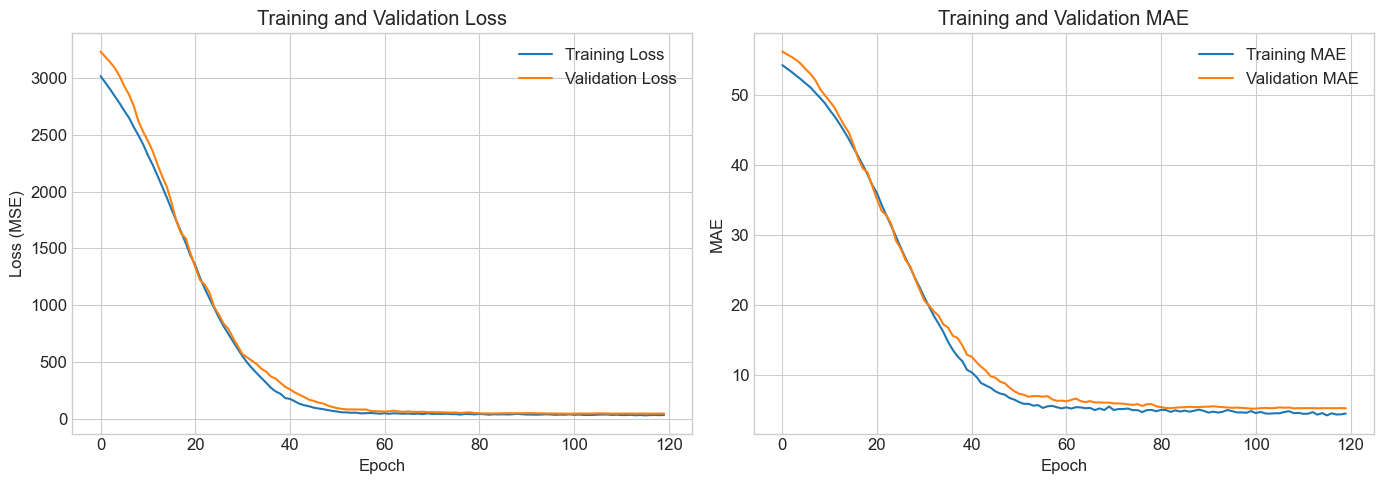

In [82]:
"""Plot training history."""
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# MAE plot
axes[1].plot(history.history['mae'], label='Training MAE')
axes[1].plot(history.history['val_mae'], label='Validation MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Training and Validation MAE')
axes[1].legend()

plt.tight_layout()
plt.savefig('outputs/figures/nn_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

In [83]:
"""Evaluate Neural Network on validation set."""
y_pred_nn = nn_model.predict(X_val_processed, verbose=0).flatten()
results.append(evaluate_model(y_val, y_pred_nn, 'Neural Network'))


Neural Network Results:
  RMSE: 6.5471
  MAE:  5.1350
  R²:   0.4858


### 4.4 Advanced Deep Learning Model with Skip Connections

In [84]:
def build_advanced_nn(input_dim):
    """Build an advanced tabular neural network with skip connections.

    Features:
    - Skip connections (residual connections)
    - Appropriately sized architecture for small datasets
    - L2 regularization
    - Lower learning rate for stability

    Args:
        input_dim: Number of input features.

    Returns:
        keras.Model: Compiled neural network model.
    """
    inputs = layers.Input(shape=(input_dim,))

    # Initial dense block (smaller for 1000-sample dataset)
    x = layers.Dense(
        128,
        kernel_regularizer=keras.regularizers.l2(0.0005),
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    # Residual block
    x1 = layers.Dense(
        64,
        kernel_regularizer=keras.regularizers.l2(0.0005),
    )(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    x1 = layers.Dropout(0.2)(x1)

    x1 = layers.Dense(
        64,
        kernel_regularizer=keras.regularizers.l2(0.0005),
    )(x1)
    x1 = layers.BatchNormalization()(x1)

    # Skip connection (project to match dimensions)
    x_skip = layers.Dense(64)(x)
    x = layers.Add()([x1, x_skip])
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)

    # Third block
    x = layers.Dense(
        32,
        kernel_regularizer=keras.regularizers.l2(0.0005),
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.1)(x)

    # Output
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss='mse',
        metrics=['mae'],
    )

    return model


# Build model
advanced_nn = build_advanced_nn(X_train_processed.shape[1])
advanced_nn.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 95)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │     12,288 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_16[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 128)       │          0 │ activation_12[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 64)        │      8,256 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_17[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 64)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 64)        │          0 │ activation_13[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │      4,160 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_18[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 64)        │      8,256 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64)        │          0 │ batch_normalizat… │
│                     │                   │            │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 64)        │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ activation_14[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 32)        │      2,080 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_20[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 32)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 36,225 (141.50 KB)

 Trainable params: 35,649 (139.25 KB)

 Non-trainable params: 576 (2.25 KB)

In [85]:
"""Train advanced neural network with fresh callbacks."""
# Create fresh callbacks (critical: don't reuse from basic NN - callbacks carry state)
early_stopping_adv = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1,
)

reduce_lr_adv = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    min_lr=1e-6,
    verbose=1,
)

history_advanced = advanced_nn.fit(
    X_train_processed,
    y_train,
    validation_data=(X_val_processed, y_val),
    epochs=300,
    batch_size=32,
    callbacks=[early_stopping_adv, reduce_lr_adv],
    verbose=1,
)

Epoch 1/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3155.2649 - mae: 55.4557 - val_loss: 3293.2324 - val_mae: 56.6620 - learning_rate: 5.0000e-04
Epoch 2/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3127.4858 - mae: 55.2108 - val_loss: 3251.2791 - val_mae: 56.2967 - learning_rate: 5.0000e-04
Epoch 3/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3099.1414 - mae: 54.9610 - val_loss: 3226.1060 - val_mae: 56.0808 - learning_rate: 5.0000e-04
Epoch 4/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3074.3281 - mae: 54.7547 - val_loss: 3210.7346 - val_mae: 55.9515 - learning_rate: 5.0000e-04
Epoch 5/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3045.6895 - mae: 54.4905 - val_loss: 3195.9988 - val_mae: 55.8300 - learning_rate: 5.0000e-04
Epoch 6/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3016.9795 - mae: 54.2459 - val_loss: 3177.3357 - val_mae: 55.6758 - learning_rate: 5.0000e-04
Epoch 7/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2991.7419 - mae: 54.028

In [86]:
"""Evaluate advanced Neural Network on validation set."""
y_pred_advanced_nn = advanced_nn.predict(X_val_processed, verbose=0).flatten()
results.append(evaluate_model(y_val, y_pred_advanced_nn, 'Advanced Neural Network'))


Advanced Neural Network Results:
  RMSE: 7.3001
  MAE:  5.8338
  R²:   0.3607


## 5. Model Comparison and Stacking Ensemble

In [87]:
"""Create model comparison summary."""
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')

print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
display(results_df)


MODEL COMPARISON SUMMARY


,model,RMSE,MAE,R2
4,Gradient Boosting,5.031240,3.943761,0.696337
6,CatBoost,5.038830,3.937000,0.695420
5,XGBoost,5.188706,4.105429,0.677031
2,Elastic Net,5.899572,4.608570,0.582474
1,Ridge Regression,5.901180,4.595718,0.582247
0,Linear Regression,5.932224,4.618753,0.577840
3,Random Forest,6.246913,4.871755,0.531863
7,Neural Network,6.547128,5.135008,0.485786
8,Advanced Neural Network,7.300114,5.833784,0.360705


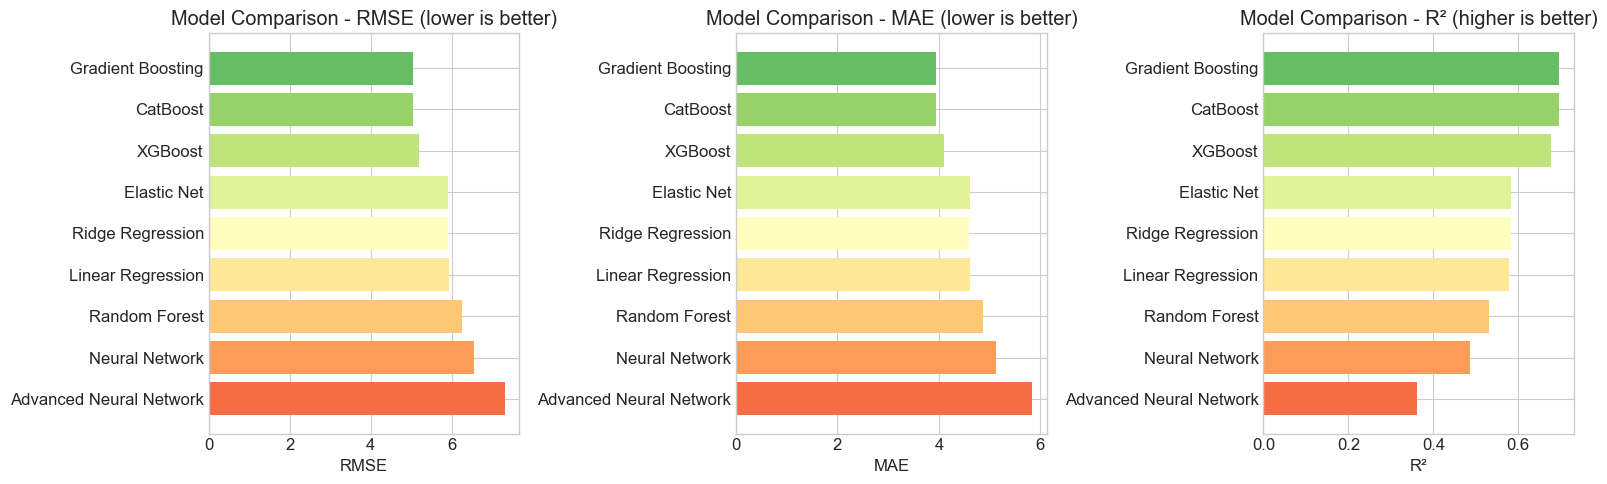

In [88]:
"""Visualize model comparison."""
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Color gradient for performance
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(results_df)))

# RMSE comparison
axes[0].barh(results_df['model'], results_df['RMSE'], color=colors)
axes[0].set_xlabel('RMSE')
axes[0].set_title('Model Comparison - RMSE (lower is better)')
axes[0].invert_yaxis()

# MAE comparison
axes[1].barh(results_df['model'], results_df['MAE'], color=colors)
axes[1].set_xlabel('MAE')
axes[1].set_title('Model Comparison - MAE (lower is better)')
axes[1].invert_yaxis()

# R² comparison
r2_colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(results_df)))
axes[2].barh(results_df['model'], results_df['R2'], color=r2_colors[::-1])
axes[2].set_xlabel('R²')
axes[2].set_title('Model Comparison - R² (higher is better)')
axes[2].invert_yaxis()

plt.tight_layout()
plt.savefig('outputs/figures/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [89]:
"""Identify the best model based on RMSE."""
best_model_name = results_df.iloc[0]['model']
best_rmse = results_df.iloc[0]['RMSE']

print(f"\nBest Model: {best_model_name}")
print(f"Validation RMSE: {best_rmse:.4f}")


Best Model: Gradient Boosting
Validation RMSE: 5.0312


### 5.1 Cross-Validation for Best Models

In [90]:
"""Perform 5-fold cross-validation on top models."""
# Prepare full training data
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# XGBoost CV with optimized params
xgb_cv = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0,
)
xgb_cv_scores = cross_val_score(
    xgb_cv, X_train_processed, y_train,
    cv=kf, scoring='neg_root_mean_squared_error',
)
print(f"XGBoost 5-Fold CV RMSE: {-xgb_cv_scores.mean():.4f} (+/- {xgb_cv_scores.std():.4f})")

# CatBoost CV with optimized params
cat_cv = CatBoostRegressor(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=3,
    rsm=0.8,
    random_state=RANDOM_STATE,
    verbose=0,
)
cat_cv_scores = cross_val_score(
    cat_cv, X_train_processed, y_train,
    cv=kf, scoring='neg_root_mean_squared_error',
)
print(f"CatBoost 5-Fold CV RMSE: {-cat_cv_scores.mean():.4f} (+/- {cat_cv_scores.std():.4f})")

# Random Forest CV with optimized params
rf_cv = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=3,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
rf_cv_scores = cross_val_score(
    rf_cv, X_train_processed, y_train,
    cv=kf, scoring='neg_root_mean_squared_error',
)
print(f"Random Forest 5-Fold CV RMSE: {-rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std():.4f})")

XGBoost 5-Fold CV RMSE: 4.8757 (+/- 0.1254)
CatBoost 5-Fold CV RMSE: 4.8103 (+/- 0.1370)
Random Forest 5-Fold CV RMSE: 5.8877 (+/- 0.2007)


### 5.2 Stacking Ensemble with Optuna Tuning

In [92]:
"""Stacking Ensemble with Optuna-Tuned Models for Final Predictions."""
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Prepare full training data
X_full = preprocessor.fit_transform(X)
X_test_final = preprocessor.transform(test_df)
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# ── Step 1: Optuna Tuning ──
print("=" * 60)
print("STEP 1: Optuna Hyperparameter Tuning")
print("=" * 60)

def objective_catboost(trial):
    params = dict(
        iterations=trial.suggest_int('iterations', 400, 1200),
        depth=trial.suggest_int('depth', 4, 8),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 0.5, 10.0),
        rsm=trial.suggest_float('rsm', 0.5, 1.0),
        bagging_temperature=trial.suggest_float('bagging_temperature', 0.0, 1.0),
        random_state=RANDOM_STATE, verbose=0,
    )
    scores = []
    for tr_idx, va_idx in kf.split(X_full):
        m = CatBoostRegressor(**params)
        m.fit(X_full[tr_idx], y.iloc[tr_idx])
        scores.append(np.sqrt(mean_squared_error(y.iloc[va_idx], m.predict(X_full[va_idx]))))
    return np.mean(scores)

print("\nTuning CatBoost (10 trials)...")
study_cat = optuna.create_study(direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study_cat.optimize(objective_catboost, n_trials=10)
print(f"  Best CV RMSE: {study_cat.best_value:.4f}")
print(f"  Best params: {study_cat.best_params}")
best_cat_params = study_cat.best_params
best_cat_params.update(dict(random_state=RANDOM_STATE, verbose=0))

def objective_xgb(trial):
    params = dict(
        n_estimators=trial.suggest_int('n_estimators', 400, 1200),
        max_depth=trial.suggest_int('max_depth', 3, 8),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        subsample=trial.suggest_float('subsample', 0.6, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1.0),
        min_child_weight=trial.suggest_int('min_child_weight', 1, 10),
        reg_alpha=trial.suggest_float('reg_alpha', 0.001, 10.0, log=True),
        reg_lambda=trial.suggest_float('reg_lambda', 0.001, 10.0, log=True),
        random_state=RANDOM_STATE, n_jobs=-1, verbosity=0,
    )
    scores = []
    for tr_idx, va_idx in kf.split(X_full):
        m = XGBRegressor(**params)
        m.fit(X_full[tr_idx], y.iloc[tr_idx])
        scores.append(np.sqrt(mean_squared_error(y.iloc[va_idx], m.predict(X_full[va_idx]))))
    return np.mean(scores)

print("\nTuning XGBoost (10 trials)...")
study_xgb = optuna.create_study(direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study_xgb.optimize(objective_xgb, n_trials=10)
print(f"  Best CV RMSE: {study_xgb.best_value:.4f}")
print(f"  Best params: {study_xgb.best_params}")
best_xgb_params = study_xgb.best_params
best_xgb_params.update(dict(random_state=RANDOM_STATE, n_jobs=-1, verbosity=0))

# ── Step 2: Stacking Ensemble ──
print("\n" + "=" * 60)
print("STEP 2: Stacking Ensemble (5-Fold OOF)")
print("=" * 60)

def make_model(name):
    if name == 'CatBoost':
        return CatBoostRegressor(**best_cat_params)
    elif name == 'XGBoost':
        return XGBRegressor(**best_xgb_params)
    elif name == 'GradBoost':
        return GradientBoostingRegressor(
            n_estimators=400, max_depth=4, learning_rate=0.05,
            subsample=0.8, min_samples_split=5, min_samples_leaf=3,
            random_state=RANDOM_STATE)
    elif name == 'RandomForest':
        return RandomForestRegressor(
            n_estimators=400, max_depth=15, min_samples_split=3,
            min_samples_leaf=2, max_features='sqrt',
            random_state=RANDOM_STATE, n_jobs=-1)

model_names = ['CatBoost', 'XGBoost', 'GradBoost', 'RandomForest']
n_models = len(model_names)

oof_preds = np.zeros((len(y), n_models))
test_preds_folds = np.zeros((len(test_df), n_models, 5))

for j, name in enumerate(model_names):
    print(f"\n  Training {name} (5-fold)...")
    for fold_idx, (tr_idx, va_idx) in enumerate(kf.split(X_full)):
        model = make_model(name)
        model.fit(X_full[tr_idx], y.iloc[tr_idx])
        oof_preds[va_idx, j] = model.predict(X_full[va_idx])
        test_preds_folds[:, j, fold_idx] = model.predict(X_test_final)
    oof_rmse = np.sqrt(mean_squared_error(y, oof_preds[:, j]))
    print(f"    {name} OOF RMSE: {oof_rmse:.4f}")

test_preds = test_preds_folds.mean(axis=2)

# ── Step 3: Meta-Learner ──
print("\n" + "=" * 60)
print("STEP 3: Ridge Meta-Learner")
print("=" * 60)

meta_model = RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0])
meta_model.fit(oof_preds, y)

print(f"\n  Best alpha: {meta_model.alpha_}")
print(f"  Model weights:")
for name, coef in zip(model_names, meta_model.coef_):
    print(f"    {name}: {coef:.4f}")
print(f"    Intercept: {meta_model.intercept_:.4f}")

oof_stacked = meta_model.predict(oof_preds)
stacked_oof_rmse = np.sqrt(mean_squared_error(y, oof_stacked))
best_single_oof = min(np.sqrt(mean_squared_error(y, oof_preds[:, j])) for j in range(n_models))
improvement = (best_single_oof - stacked_oof_rmse) / best_single_oof * 100

print(f"\n  Stacked OOF RMSE:      {stacked_oof_rmse:.4f}")
print(f"  Best single model OOF: {best_single_oof:.4f}")
print(f"  Improvement:           {improvement:.2f}%")

final_predictions = meta_model.predict(test_preds)
final_predictions = np.clip(final_predictions, 20, 120)

print(f"\n  Final Prediction Statistics:")
print(f"    Mean: {final_predictions.mean():.2f}")
print(f"    Std:  {final_predictions.std():.2f}")
print(f"    Min:  {final_predictions.min():.2f}")
print(f"    Max:  {final_predictions.max():.2f}")

STEP 1: Optuna Hyperparameter Tuning

Tuning CatBoost (10 trials)...
  Best CV RMSE: 4.7277
  Best params: {'iterations': 1066, 'depth': 5, 'learning_rate': 0.015199348301309814, 'l2_leaf_reg': 2.2423428436076214, 'rsm': 0.6521211214797689, 'bagging_temperature': 0.5247564316322378}

Tuning XGBoost (10 trials)...
  Best CV RMSE: 4.6978
  Best params: {'n_estimators': 470, 'max_depth': 4, 'learning_rate': 0.011097554561103107, 'subsample': 0.7301321323053057, 'colsample_bytree': 0.6943386448447411, 'min_child_weight': 3, 'reg_alpha': 2.065142557895926, 'reg_lambda': 0.026730883107816707}

STEP 2: Stacking Ensemble (5-Fold OOF)

  Training CatBoost (5-fold)...
    CatBoost OOF RMSE: 4.7318

  Training XGBoost (5-fold)...
    XGBoost OOF RMSE: 4.7031

  Training GradBoost (5-fold)...
    GradBoost OOF RMSE: 4.8308

  Training RandomForest (5-fold)...
    RandomForest OOF RMSE: 5.8315

STEP 3: Ridge Meta-Learner

  Best alpha: 100.0
  Model weights:
    CatBoost: 0.4397
    XGBoost: 0.8245

In [93]:
"""Stacking ensemble complete - final_predictions ready for submission."""
print("Stacking ensemble predictions generated successfully!")
print(f"Predictions shape: {final_predictions.shape}")

Stacking ensemble predictions generated successfully!
Predictions shape: (200,)


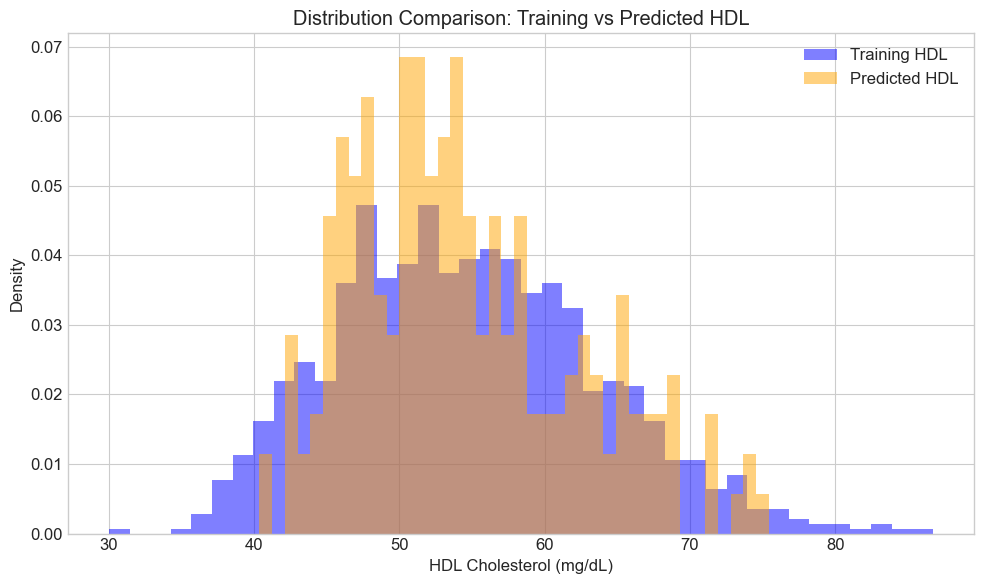

In [94]:
"""Compare prediction distribution with training target distribution."""
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(
    y,
    bins=40,
    alpha=0.5,
    label='Training HDL',
    density=True,
    color='blue',
)
ax.hist(
    final_predictions,
    bins=40,
    alpha=0.5,
    label='Predicted HDL',
    density=True,
    color='orange',
)

ax.set_xlabel('HDL Cholesterol (mg/dL)')
ax.set_ylabel('Density')
ax.set_title('Distribution Comparison: Training vs Predicted HDL')
ax.legend()

plt.tight_layout()
plt.savefig('outputs/figures/prediction_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [95]:
"""Save predictions to CSV for submission."""
submission = pd.DataFrame({'pred': final_predictions})
submission.to_csv('outputs/pred.csv', index=False)

print("Predictions saved to outputs/pred.csv")
print(f"\nSubmission file preview:")
display(submission.head(10))
print(f"\nTotal predictions: {len(submission)}")

Predictions saved to pred.csv

Submission file preview:


,pred
0,47.962090
1,54.476965
2,59.418100
3,47.136230
4,41.010684
5,65.298220
6,45.105302
7,63.775620
8,48.138957
9,55.507481



Total predictions: 200


## 6. Summary and Conclusions

In [ ]:
"""Display final summary of the analysis."""
print("=" * 70)
print("HDL CHOLESTEROL PREDICTION - FINAL SUMMARY")
print("=" * 70)

print("\n1. DATA OVERVIEW:")
print(f"   - Training samples: {len(train_df)}")
print(f"   - Test samples: {len(test_df)}")
print(f"   - Number of features: {X.shape[1]}")
print(f"   - Target mean: {y.mean():.2f} mg/dL")
print(f"   - Target std: {y.std():.2f} mg/dL")

print("\n2. KEY FINDINGS FROM EDA:")
print(f"   - Features with >50% missing: {(missing_pct > 50).sum()}")
print(
    f"   - Target distribution is approximately normal "
    f"(skewness: {train_df[TARGET_COL].skew():.3f})"
)
print("   - Strong negative correlation with body measures (BMI, waist)")

print("\n3. MODEL PERFORMANCE (Validation RMSE):")
for _, row in results_df.head(5).iterrows():
    print(f"   - {row['model']}: {row['RMSE']:.4f}")

print("\n4. FINAL MODEL:")
print("   - Stacking ensemble with Ridge meta-learner")
print("   - Optuna-tuned CatBoost and XGBoost as base models")
print("   - Additional base models: Gradient Boosting, Random Forest")
print(f"   - Stacked OOF RMSE: {stacked_oof_rmse:.4f}")

print("\n5. OUTPUT FILES:")
print("   - pred.csv: Final predictions for submission")
print("   - Various PNG files with visualizations")

print("\n" + "=" * 70)

## References

1. NHANES Program Overview: https://www.cdc.gov/nchs/nhanes/about/index.html
2. ASA South Florida Student Data Challenge: https://luminwin.github.io/ASASF/
3. XGBoost Documentation: https://xgboost.readthedocs.io/
4. CatBoost Documentation: https://catboost.ai/docs/
5. TensorFlow/Keras Documentation: https://www.tensorflow.org/api_docs
6. Scikit-learn Documentation: https://scikit-learn.org/stable/
7. Optuna Documentation: https://optuna.readthedocs.io/